# OBJ Viewer

__loading obj file, transforms, textures and shading__


In [1]:
try: # install all dependencies in colab 
    import google.colab
    !sudo apt-get update -y
    !sudo apt-get install -y libnvidia-gl-555 vulkan-tools glslang-tools vulkan-validationlayers-dev
    !pip install pyav==13.1.0
    !pip install git+https://github.com/rendervous/vulky_project.git
except:
    print("Executing locally")

Executing locally


In [2]:
import vulky as vk
import numpy as np
import vulky.datasets as datasets

vk.create_device(debug=True)
SCREEN_WIDTH = 512
SCREEN_HEIGHT = 512
render_target = vk.render_target(
    image_format=vk.Format.VEC4,
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)
depth_buffer = vk.depth_stencil(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT
)

[INFO] Debug instance created...
[PRINT] Inserted device layer "VK_LAYER_KHRONOS_validation" (C:\VulkanSDK\1.3.275.0\Bin\.\VkLayer_khronos_validation.dll)
[PRINT] Inserted device layer "VK_LAYER_OBS_HOOK" (C:\ProgramData\obs-studio-hook\.\graphics-hook64.dll)
[PRINT] Inserted device layer "VK_LAYER_NV_optimus" (C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll)
[PRINT] vkCreateDevice layer callstack setup to:
[PRINT]    <Application>
[PRINT]      ||
[PRINT]    <Loader>
[PRINT]      ||
[PRINT]    VK_LAYER_NV_optimus
[PRINT]            Type: Implicit
[PRINT]                Disable Env Var:  DISABLE_LAYER_NV_OPTIMUS_1
[PRINT]            Manifest: C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\nv-vk64.json
[PRINT]            Library:  C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_cc569e59ca39c5fe\.\nvoglv64.dll
[PRINT]      ||
[PRINT]    VK_LAYER_OBS_HOOK
[PRINT]            Type: Implici

In [3]:
# data = vk.load_obj('./vulky_data/bunny.obj')
data = datasets.Meshes.bunny  # loads the bunny obj

In [4]:
vertices, indices = vk.create_mesh(data, mode='po')

In [5]:
vertex_buffer = vk.vertex_buffer(len(vertices), element_description=dict(
    P=vk.vec3,
    N=vk.vec3,
    C=vk.vec2
)).load(vertices)

number_of_indices = indices.numel()
index_buffer = vk.index_buffer(number_of_indices).load(indices)

In [6]:
global_transform = vk.object_buffer(
    vk.Layout.from_structure(
        vk.LayoutAlignment.SCALAR,
        Proj=vk.mat4,
        View=vk.mat4
    )
)

with global_transform as b:
    b.Proj = vk.mat4.perspective()
    b.View = vk.mat4.look_at(vk.vec3(0., 1., -4.), vk.vec3(0., 0., 0.), vk.vec3(0.,1., 0.))

local_transforms = [
    vk.object_buffer(
        vk.Layout.from_structure(
            vk.LayoutAlignment.SCALAR,
            World=vk.mat4
        ),
        memory=vk.MemoryLocation.GPU
    ) for o in range(3)
]

for i, b in enumerate(local_transforms):
    with b as t:
        t.World = vk.mat4.trs(vk.vec3(np.cos(i * 6.28 / 3), -0.2, np.sin(i * 6.28 / 3)), vk.vec3(0., 1., 0.0), i*3.14159/3, vk.vec3.one())

In [7]:
vertex_shader_code = """
#version 450
#extension GL_EXT_scalar_block_layout: enable

layout(location = 0) in vec3 in_position;
layout(location = 1) in vec3 in_normals;
layout(location = 2) in vec2 in_coordinates;
layout(location = 0) out vec3 out_position;
layout(location = 1) out vec3 out_normals;
layout(location = 2) out vec2 out_coordinates;

layout(std430, set=0, binding=0) uniform Globals{
    mat4 Proj;
    mat4 View;
};

layout(std430, set=1, binding=1) uniform Locals{
    mat4 World;
};

void main()
{
    vec4 P = vec4(in_position, 1.0);
    P = World * P;
    out_position = P.xyz;
    gl_Position = Proj * (View * P);
    vec4 N = vec4(in_normals, 0.0);
    out_normals = (World * N).xyz;
    out_coordinates = in_coordinates;
}
"""

fragment_shader_code = """
#version 450
layout(location = 0) in vec3 in_position;
layout(location = 1) in vec3 in_normals;
layout(location = 2) in vec2 in_coordinates;
layout(location = 0) out vec4 out_color;
void main() {
    // out_color = vec4(in_coordinates, 0, 1.0);
    out_color = vec4(in_normals*0.5+0.5, 1.0);
}
"""

In [8]:
pipeline = vk.pipeline_graphics()
pipeline.attach(slot=0, render_target=vk.Format.VEC4)
pipeline.attach(slot=1, depth_buffer=vk.Format.DEPTH_STENCIL)
pipeline.layout(set=0, binding=0, global_transform=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.layout(set=1, binding=1, local_transform=vk.DescriptorType.UNIFORM_BUFFER)
pipeline.vertex(location=0, in_position=vk.Format.VEC3)
pipeline.vertex(location=1, in_normals=vk.Format.VEC3)
pipeline.vertex(location=2, in_coordinates=vk.Format.VEC2)
pipeline.vertex_binding(
    binding=0,
    stride=(3+3+2)*4,
    in_position=0,
    in_normals=3*4,
    in_coordinates=6*4,
)
with pipeline.shader_stages(vk.ShaderStage.VERTEX):
    pipeline.load_shader_from_source(vertex_shader_code)
with pipeline.shader_stages(vk.ShaderStage.FRAGMENT):
    pipeline.load_shader_from_source(fragment_shader_code)
pipeline.close()

In [9]:
global_bindings = pipeline.create_descriptor_set_collection(set=0, count=1)
global_bindings[0].update(global_transform=global_transform)
local_bindings = pipeline.create_descriptor_set_collection(set=1, count=len(local_transforms))
for i, lt in enumerate(local_transforms):
    local_bindings[i].update(
        local_transform=local_transforms[i]
    )

framebuffer = pipeline.create_framebuffer(
    width=SCREEN_WIDTH,
    height=SCREEN_HEIGHT,
    render_target=render_target,
    depth_buffer=depth_buffer
)

In [10]:
man = vk.graphics_manager()
man.clear_color(render_target, (0.0, 0.0, 0.4, 1.))
man.clear_depth_stencil(depth_buffer, 1.0, 0)
man.set_pipeline(pipeline)
man.set_framebuffer(framebuffer)
man.bind(global_bindings[0])

In [11]:
man.bind_vertex_buffer(0, vertex_buffer)
man.bind_index_buffer(index_buffer)

In [12]:
for i in range(len(local_transforms)):
    man.bind(local_bindings[i])
    man.dispatch_indexed_primitives(number_of_indices)
man.freeze()

In [13]:
vk.submit(man)

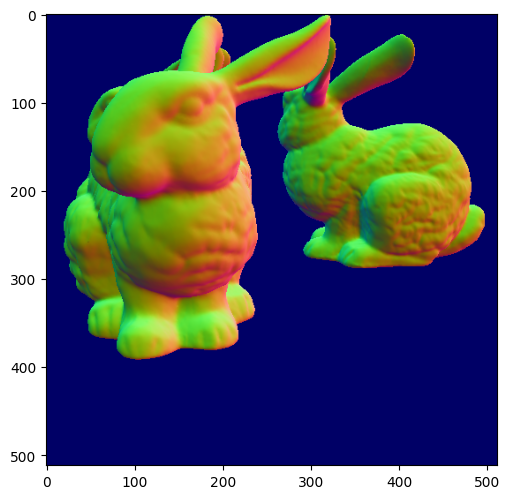

In [14]:
import matplotlib.pyplot as plt
staging = vk.tensor(render_target.height, render_target.width, 4)  
render_target.save(staging)
# visualize the tensor with matplotlib
plt.imshow(staging.cpu())
# plt.gca().axis('off')
plt.tight_layout(pad=0.0)
plt.show()

Let's create the video!

In [15]:
video_data = vk.tensor(100, SCREEN_HEIGHT, SCREEN_WIDTH, 3)  # 100 frames

In [16]:
# populate
for i in range(len(video_data)):
    alpha = i / len(video_data)
    look_at = vk.vec3(np.cos(alpha * 7), np.sin(alpha)*0.1 + 0.2, np.sin(alpha * 7))*(5 + np.sin(alpha))
    # we dont need to map because is permanently mapped and update is always CPU -> GPU
    with global_transform as b:
        b.View = vk.mat4.look_at(look_at, vk.vec3(0., 0., 0.), vk.vec3(0.,1., 0.))
    vk.submit(man)
    render_target.save(staging)
    video_data[i] = staging[...,:3]  # copy current frame to video (only RGB)    


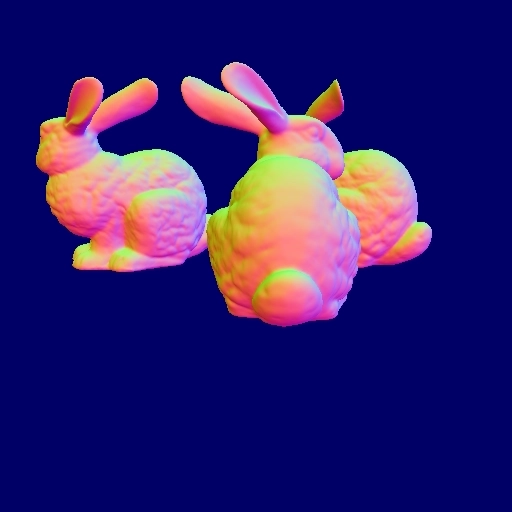

In [17]:
vk.save_video(video_data, 'teaser5.webp', 10, quality=100)
import moviepy.editor
moviepy.editor.ipython_display("teaser5.webp", filetype='image')